In [1]:
# importing `config.py` to access its variables and other needed dependensies
import config
from tweepy import Client
import tweepy
import pandas as pd
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
%matplotlib inline
from transformers import pipeline, AutoModelForSequenceClassification, AutoTokenizer

## connecting to twitter API v2 and loading the tweets into Dataframe 

In [2]:
#getting recent tweets data
def getTweets():
    #asking for the search term and the desired number of tweets
    global keyword 
    keyword = input('insert search term : ')
    query = f'{keyword} -is:retweet lang:en'
    num_tweets = int(input('how many tweets do you want? '))
    #connecting to the twitter API using clent and the bearer_token credentials from config.py
    client = Client(config.bearer_token)

    #using tweepy paginator to get over 100 last tweets from twitter api
    tweets = []
    for tweet in tweepy.Paginator(client.search_recent_tweets,
                                    query = query,                             
                                    tweet_fields = ['id','created_at', 'public_metrics', 'text', 'source'],
                                    max_results = 100).flatten(limit=num_tweets):
    
        tweets.append(tweet)
    return tweets


#function to clean the tweets and load them into a DataFrame
def tweetsETL(tweets):
    
    result = []
    
    #regex function to clean the tweet text from haashtags, mentions and links
    def cleanTweets(text):
        clean_text = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",text).split())
        return clean_text
    
    #function to unpack the tweets list into a dataframe
    for tweet in tweets:
            result.append({'id': tweet.id,
                           'text': tweet.text,
                           'clean_tweet' : cleanTweets(tweet.text),
                           'created_at': tweet.created_at,
                           'source':tweet.source,
                           'retweets': tweet.public_metrics['retweet_count'],
                           'replies': tweet.public_metrics['reply_count'],
                           'likes': tweet.public_metrics['like_count'],
                           'quote_count': tweet.public_metrics['quote_count']
                      })

    df = pd.DataFrame(result)
    return df

## performing the sentiment analysis using a base BERT model

In [3]:
#using a transformers model "bert" to perform the sentiment analysis on the clean_tweets column.
def sentimentAnalysis(df):
    tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
    model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
    classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)
    res = df['clean_tweet'].apply(lambda x: classifier(x[:512]))
    return res

## function to add the list resulting from the analysis to the original dataframe as score, sentiment and stars
#the sentiment is either negative, positive or neutral, and the number of stars go from 1 to 5
#1 being the most negative sentiment and 5 being the most positive
def sentimentToDf(df,res):
    tweets_stars = []
    tweets_scores = []
    tweets_sentiment = []
    #looping over the list of result to unpack it into the original tweets dataframe
    for i in range(res.size):
        tweets_stars.append(int(float(res[i][0]['label'].split()[0])))
        tweets_scores.append(res[i][0]['score'])
        if res[i][0]['label'] == '4 stars' or res[i][0]['label'] == '5 stars':
            tweets_sentiment.append('positive')
        elif res[i][0]['label'] == '1 star' or res[i][0]['label'] == '2 stars':
            tweets_sentiment.append('negative')
        else :
            tweets_sentiment.append('neutral')
    df['scores'] = tweets_scores
    df['sentiment'] = tweets_sentiment  
    df['stars'] = tweets_stars
    return df

#fucntion to Create the wordclouds using data frpom a column of a dataframe
def creatWordCloud(df,clm_name):
    text = " ".join(line for line in df[clm_name])
    # Create the wordcloud object
    wordcloud = WordCloud(width=980, height=580, margin=0,collocations = False, background_color = 'white').generate(text)
    # Display the generated image:
    plt.figure(figsize=(12,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.margins(x=0, y=0)
    plt.show()
    return plt 


## Creating report function to get insight from the analyzed tweets

In [9]:
#creating a function to show the result of the sentiment analysis from the final df   
def showReport(df):     
    print(f'* the tweets show that the sentiment around "{keyword}" is mainly {df.groupby(by="sentiment").id.count().sort_values(ascending=False).index[0] }')
    print(f'* this is how the overall sentiment and stars ratings breakdown on the {len(df)} total records we recovered : ')
    print(df.groupby(["stars"]).count()['id'])
    
     # Build the percentage of star count reviews by category pie chart.
    star_perc = 100 * df.groupby(["stars"]).count()['id'] / len(df)
    plt.pie(star_perc,
            labels=["1 star", "2 stars", "3 stars", '4 stars', '5 stars'],
            colors=["red", "orange", "gold", 'turquoise', 'green'],
            explode=[0.05, 0.05, 0.05, 0.05, 0.05],
            autopct='%1.1f%%',
            shadow=True, startangle=150),
    plt.title("percentage of Total tweets by star ratings")
    # Show Figure
    plt.show()
     # Build the sentiment reviews by category pie chart.
    sent_perc = 100 * df.groupby(["sentiment"]).count()['id'] / len(df)   
    plt.pie(sent_perc,
            labels=["Negative", "Neutral", "Positive",],
            colors=["red", "gold", 'green'],
            explode=[0.05, 0.05, 0.05],
            autopct='%1.1f%%',
            shadow=True, startangle=150),
    plt.title("percentage of total tweets by sentiment ")
    # Show Figure
    plt.show()
    
#function to creat word clouds for each tweet sentiment
def sentimentWordcloud(df):
    print("We generate Wordclouds for each sentiment to see the words that appear most often for each one :")
    print("_________________________________________________________________________________________________")
    print('Wordcloud for negative sentiment tweets : ')
    creatWordCloud(df.query('sentiment == "negative"'),"clean_tweet")
    print('Wordcloud for neutral sentiment tweets : ')
    creatWordCloud(df.query('sentiment == "neutral"'),"clean_tweet")
    print('Wordcloud for positive sentiment tweets : ')
    creatWordCloud(df.query('sentiment == "positive"'),"clean_tweet")

## creating call function to streamline the process

In [5]:
# creating call functions

def tweetTodf():
    print ("this is a simple twitter sentiment analysis bot, please follow the instuction to know twitter's last thoughts. \n- the tweets collected are the last specified number of tweets about a keyword of your choice")
    print ('connection to twitter IPA')
    df = tweetsETL(getTweets())
    print ('retrieving tweets -- ')
    return df

def sentimentTodf(df):
    print('-----------------------------------------')
    print('sentiment analysis in progress.')
    print('this might take a minute ...')
    final_df = sentimentToDf(df,sentimentAnalysis(df))
    print('-----------------------------------------')
    return final_df

def finalReport(final_df):
    print('creating report ...')
    print(f'the report represents the sentiment around "{keyword}", stars represent the sentiment of a tweet \n from 1 being most negative to 5 being most positive ...')
    print("_________________________________________________________________________________________________\n")
    showReport(final_df)
    sentimentWordcloud(final_df)
    
    


## running the process

this is a simple twitter sentiment analysis bot, please follow the instuction to know twitter's last thoughts. 
- the tweets collected are the last specified number of tweets about a keyword of your choice
connection to twitter IPA
insert search term : Joe biden
how many tweets do you want? 3454
retrieving tweets -- 
-----------------------------------------
sentiment analysis in progress.
this might take a minute ...
-----------------------------------------
creating report ...
the report represents the sentiment around "Joe biden", stars represent the sentiment of a tweet 
 from 1 being most negative to 5 being most positive ...
_________________________________________________________________________________________________

* the tweets show that the sentiment around "Joe biden" is mainly negative
* this is how the overall sentiment and stars ratings breakdown on the 3454 total records we recovered : 
stars
1    2210
2     146
3     283
4     270
5     545
Name: id, dtype: int64


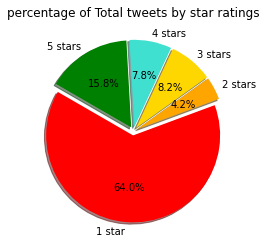

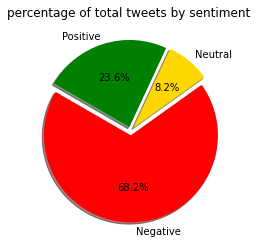

We generate Wordclouds for each sentiment to see the words that appear most often for each one :
_________________________________________________________________________________________________
Wordcloud for negative sentiment tweets : 


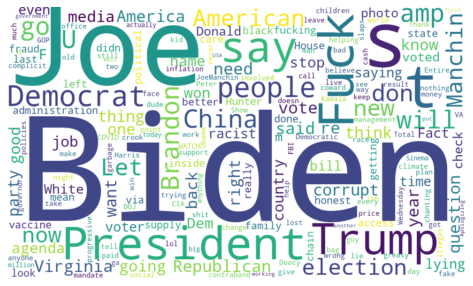

Wordcloud for neutral sentiment tweets : 


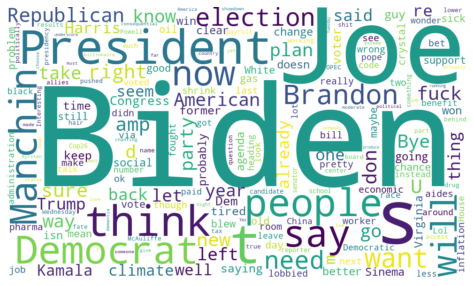

Wordcloud for positive sentiment tweets : 


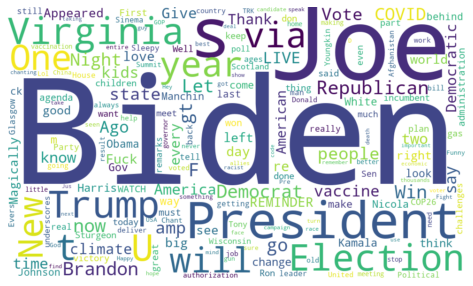

In [8]:
finalReport(sentimentTodf(tweetTodf()))